In [1]:
import numpy as np
import pandas as pd

# cross validation purposes: create the cartesian product between the chosen values sets
from itertools import product 

#import os
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Read Dataset

In [2]:
cmp = pd.read_csv("commViolUnnormData.txt", na_values='?')

In [3]:
# drop first non predictive features (communityname, state, countyCode, communityCode, "fold")
pred_features = cmp[cmp.columns[5:-18]]
regr_values = cmp[cmp.columns[-18:]]

# Drop features with a lot of missing values

In [4]:
print("Before dropping: {} features".format(str(pred_features.shape[1])))

#drop features that contain at least some threshold (from the total) of NaN values
cut_tresh = 0.75
to_drop = pred_features.columns[pred_features.count() < pred_features.shape[0]*cut_tresh]

pred_features = pred_features.drop(columns=to_drop)

print("After dropping: {} features".format(str(pred_features.shape[1])))

Before dropping: 124 features
After dropping: 102 features


# Imputing on features matrix

In [5]:
from collections import Counter

def value_withStrategy(v, strat):
    if strat == "mean":
        return np.mean(v)
    if strat == "median":
        return np.median(v)
    if strat == "most_frequent":
        return Counter(v).most_common(1)[0][0]
    print("Invalid imputing strategy!")
        
def imputing(df, strategy):
    # for each column that contain at least 1 NaN value...
    for nanCol in np.unique(np.where(pred_features.isna())[1]):
        nanRows = np.where(pred_features.iloc[:,nanCol].isna())[0] #find NaN rows for the current column
        available = df.iloc[~nanRows, nanCol]
        value = value_withStrategy(available, strategy) #compute the filling value
        df.iloc[nanRows, nanCol] = value

In [6]:
imputing(pred_features, "mean");

# Outliers Detection

-- TBD <br>
A thourough study from scratch of outliers detection is needed here, but for now it feels like it exceeds the course final project.

# Choose the Dependent Variable and drop possible missing values rows on it

In [7]:
def drop_naSample(df, vals):
    idxRow = np.where(vals.isna())[0]
    return df.drop(index=idxRow).values, vals.drop(index=idxRow).values.reshape(-1,1)

In [8]:
dep_var = "robbPerPop"
data,values = drop_naSample(pred_features, regr_values[dep_var])

# Normalisation

In [9]:
def normalise(matrix, strat):
    for j in range(matrix.shape[1]):
        mi = np.min(matrix[:,j])
        ma = np.max(matrix[:,j])
        di = ma-mi
        if (di > 1e-6):
            if strat=="0_mean,1_std":
                matrix[:,j] = (matrix[:,j]-np.mean(matrix[:,j]))/np.std(matrix[:,j])
            elif strat=="[0,1]":
                matrix[:,j] = (matrix[:,j]-mi)/di
            elif strat=="[-1,1]":
                matrix[:,j] = 2*((matrix[:,j]-mi)/di)-1
            else:
                print("Invalid normalisation strategy!")
        else:
            matrix[:,j] = 0

In [10]:
strategy = "[-1,1]"
normalise(data,strategy)
normalise(values,strategy)

# Train-Test Split

In [11]:
def trainTest_split(in_matrix, out_vect, train_amount=0.7):
    n,_ = in_matrix.shape

    trVl_Amount = int(n*train_amount) #training-validation amount
    indexes = np.random.permutation(n)
    idxTrVl = np.sort(indexes[0:trVl_Amount])
    idxTs = np.sort(indexes[trVl_Amount:])

    return in_matrix[idxTrVl], in_matrix[idxTs], out_vect[idxTrVl], out_vect[idxTs]

In [12]:
trainVal_data, test_data, trainVal_values, test_values = trainTest_split(data, values, train_amount=0.7)

# Evaluation Metrics

In [13]:
class Regression_evaluationMetric:
    def __init__(self, true, predicted):
        self.true = true.flatten()
        self.predicted = predicted.flatten()
        self.residuals = self.true-self.predicted
    
    def meanSquareError(self):
        return np.mean(np.square(self.residuals))
    
    def rootMeanSquareError(self):
        return np.sqrt(np.mean(np.square(self.residuals)))
    
    def meanAbsoluteError(self):
        return np.mean(np.abs(self.residuals))
    
    def rSquared(self):
        ss_residual = np.sum(np.square(self.residuals))
        ss_total = np.sum(np.square(self.true-np.mean(self.true)))        
        return 1 - ss_residual/ss_total
    
    def adjusted_rSquared(self, p):
        n = self.true.shape[0]
        return 1-(1-self.rSquared())*((n-1)/(n-p-1))


# Variable Selection - Models Definition

## 0. K-fold Cross Validation

In [14]:
from itertools import product

def kFold_crossValidation_selectionGrid(k, parameters_dict, train_data, train_values, predictor, verbose=False):
    nVal,_ = train_data.shape
    
    # Validation indexes adjustment -------------------------------
    elemPerFold, remainder = np.divmod(nVal,k) #the remainder will be distributed across the firsts folds
    valIdxList = []
    start = 0

    # in each fold put as many samples as the division quotient +1 if the remainder is still positive
    # then decrease the division remainder by 1
    for i in range(k): 
        end = start+elemPerFold+int(remainder>0)
        valIdxList.append(np.arange(start,end)) 
        remainder -= 1
        start = end
    
    # Cross validation --------------------------------------------
    params_names = parameters_dict.keys()
    params_product = list(product(*parameters_dict.values())) # build all the hyp-par combination
    val_results = np.empty((len(valIdxList),len(params_product)))
    
    for row, valIdx in enumerate(valIdxList): # for each fold
        if verbose: print("#{} fold:".format(row+1))
        for col, params in enumerate(params_product):
            
            if verbose:
                update = col*100/len(params_product) # just print completion rate
                print("\t["+"#"*(int(update/5))+" "*(int((100-update)/5))+"] {}%".format(update))
                     
            arg_dict = {k:v for k,v in zip(params_names,params)} # {argument_name:argument_value, ... }
            
            
            predictor.fit(train_data[~valIdx], train_values[~valIdx], **arg_dict)
            pred = predictor.predict(train_data[valIdx])
            
            rem = Regression_evaluationMetric(trainVal_values[valIdx], pred)
            #val_results[row,col] = rem.rSquared()
            val_results[row,col] = rem.rootMeanSquareError()
            
    selected = np.argmin(val_results.mean(axis=0))
    return params_product[selected]

## 1. Matching Pursuit - Not Working (use the sklearn model)

### Project class definition

In [15]:
class matchingPursuit:
    def __init__(self, iterations, weights = None, indexes = None):
        self.iterations = iterations
        self.weights = weights
        self.indexes = indexes
        
    def fit(self, data_matrix, output_vect):
        residual = output_vect.copy()
        self.weights = np.zeros((data_matrix.shape[1], 1))
        self.indexes = []

        #data_2norm = np.sqrt(np.sum(np.square(data_matrix), axis=0))
        data_2norm = np.linalg.norm(data_matrix, ord=2, axis=0).reshape(1,-1)

        for i in range(self.iterations):
            
            # project each column on the current residuals
            projection = np.matmul(residual.T, data_matrix)
            # find the most correlated variable: the one that in norm maximise the projections
            k = np.argmax(np.divide(np.square(projection), data_2norm))
            self.indexes.append(k)
            
            distance = projection[0,k]/np.linalg.norm(data_matrix[:,k], ord=2)
            self.weights[k,0] += distance # update the solution vector: canonical basis over the found column
            residual -= np.matmul(data_matrix, self.weights) # update the residual

        return self
    
    
    def predict(self, X):
        if self.weights is None:
            raise Exception("weights not initialised! need to first fit the model")
        return np.matmul(X, self.weights)
    
    
    def sort_featureImportances(self, columns=None, num=0):
        if self.weights is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.weights)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(zip(range(d),self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

In [16]:
mp = matchingPursuit(iterations=10)
mp.fit(trainVal_data, trainVal_values)
mp.sort_featureImportances(columns=pred_features.columns)

[('NumStreet', array([-4.64867656e+15])),
 ('NumKidsBornNeverMar', array([33.84253309])),
 ('population', array([0.])),
 ('householdsize', array([0.])),
 ('racepctblack', array([0.])),
 ('racePctWhite', array([0.])),
 ('racePctAsian', array([0.])),
 ('racePctHisp', array([0.])),
 ('agePct12t21', array([0.])),
 ('agePct12t29', array([0.])),
 ('agePct16t24', array([0.])),
 ('agePct65up', array([0.])),
 ('numbUrban', array([0.])),
 ('pctUrban', array([0.])),
 ('medIncome', array([0.])),
 ('pctWWage', array([0.])),
 ('pctWFarmSelf', array([0.])),
 ('pctWInvInc', array([0.])),
 ('pctWSocSec', array([0.])),
 ('pctWPubAsst', array([0.])),
 ('pctWRetire', array([0.])),
 ('medFamInc', array([0.])),
 ('perCapInc', array([0.])),
 ('whitePerCap', array([0.])),
 ('blackPerCap', array([0.])),
 ('indianPerCap', array([0.])),
 ('AsianPerCap', array([0.])),
 ('OtherPerCap', array([0.])),
 ('HispPerCap', array([0.])),
 ('NumUnderPov', array([0.])),
 ('PctPopUnderPov', array([0.])),
 ('PctLess9thGrade', 

In [17]:
pred = mp.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 6.083548782132396e+27
Root Mean Square Error: 4636771543543148.0
R^2 score: -5.155517822168845e+32


### SkLearn Class

In [18]:
from sklearn.linear_model import orthogonal_mp
omp_coef = orthogonal_mp(trainVal_data, trainVal_values)
np.where(omp_coef)[0]

array([ 3, 11, 38, 50, 67, 76, 77, 92, 93, 94])

In [19]:
pred = np.matmul(test_data, omp_coef)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.07258847552889652
Root Mean Square Error: 0.11645584431344774
R^2 score: 0.6747903137943816


## 2. L1 Penalty (Lasso) with Proximal Gradient - Not Working (use the sklearn model)

### Project class definition

In [20]:
class lasso_regression: # Iterative Soft Thresholding Algorithm
    def __init__(self, iterations, weights=None):
        self.iterations = iterations
        self.weights = weights
        
    def fit(self, data_matrix, output_vect, _lambda):
        n,d = data_matrix.shape
        self.weights = np.zeros((d,1))
        
        # convergence step-size: n/(2*||X^t*X||_2)
        step = n/(2*np.linalg.norm(np.matmul(data_matrix.T, data_matrix), ord=2))
        softTresh = step*_lambda

        for i in range(self.iterations):
            # gradient step of the mse formulation
            resid = np.matmul(data_matrix, self.weights) - output_vect
            grad_descent = (step/n)*np.matmul(data_matrix.T, resid)
            self.weights -= 2*grad_descent

            # proximal operator
            upper = self.weights > softTresh  # elem to be reduced
            lower = self.weights < -softTresh # elem to be increased
            self.weights[upper] -= softTresh
            self.weights[lower] += softTresh
            self.weights[~upper & ~lower] = 0

        return self
    
    def predict(self, X):
        if self.weights is None:
            raise Exception("weights not initialised! need to first fit the model")
        return np.matmul(X, self.weights)
    
    def sort_featureImportances(self, columns=None, num=0):
        if self.weights is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.weights)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(zip(range(d),self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

In [21]:
lr = lasso_regression(iterations=1000)
lr.fit(trainVal_data, trainVal_values, 0.5)
lr.sort_featureImportances(columns=pred_features.columns)

[('NumKidsBornNeverMar', array([0.09918527])),
 ('NumInShelters', array([0.08315037])),
 ('NumStreet', array([0.08102814])),
 ('NumUnderPov', array([0.07596358])),
 ('NumImmig', array([0.0717318])),
 ('population', array([0.06103532])),
 ('numbUrban', array([0.05567671])),
 ('HousVacant', array([0.04718719])),
 ('LemasPctOfficDrugUn', array([0.02893266])),
 ('LandArea', array([0.00852695])),
 ('householdsize', array([0.])),
 ('racepctblack', array([0.])),
 ('racePctWhite', array([0.])),
 ('racePctAsian', array([0.])),
 ('racePctHisp', array([0.])),
 ('agePct12t21', array([0.])),
 ('agePct12t29', array([0.])),
 ('agePct16t24', array([0.])),
 ('agePct65up', array([0.])),
 ('pctUrban', array([0.])),
 ('medIncome', array([0.])),
 ('pctWWage', array([0.])),
 ('pctWFarmSelf', array([0.])),
 ('pctWInvInc', array([0.])),
 ('pctWSocSec', array([0.])),
 ('pctWPubAsst', array([0.])),
 ('pctWRetire', array([0.])),
 ('medFamInc', array([0.])),
 ('perCapInc', array([0.])),
 ('whitePerCap', array([0.

In [22]:
pred = lr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.03854860375202811
Root Mean Square Error: 0.31678516219727826
R^2 score: -1.4064151814525911


### SkLearn Class

In [23]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.005)
lasso.fit(trainVal_data, trainVal_values)
np.where(lasso.coef_)[0]

array([  3,  11,  38,  44,  50,  76,  93,  94, 100])

In [24]:
pred = lasso.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.0650983258776175
Root Mean Square Error: 0.12289048966747763
R^2 score: 0.6378592097328893


## 3. Random Forest

### Project Decision Tree class definition

In [25]:
class NumericalDecisionTree_regressor: # Least Square Regression Tree with either fixed parameter or pruning
    class Node:
        def __init__(self, isLeaf=False, feature=None, feature_importance=None, cut=None, average=None,
                     left=None, right=None):
            self.isLeaf = isLeaf
            self.feature = feature # if internal, on wich feature it executes the split
            self.feature_importance = feature_importance # solution variance reduction
            self.cut = cut # if internal, threahold value for the cut
            self.avg = average # mean of seen training values
            self.left = left
            self.right = right

        def print_tree(self):
            if self.left: self.left.print_tree()
            if self.cut:
                print("Feature: {}, cut: {}\n".format(self.feature, self.cut))
            else:
                print("Leaf => {}\n".format(self.avg))
            if self.right: self.right.print_tree()

        def print_tree_indented(self, level=0):
            if self.right: self.right.print_tree_indented(level+1)
            if self.cut:
                print("|    "*level+"{} => {}".format(self.feature, self.cut))
            else:
                print("|    "*level+"Leaf: {}".format(self.avg))                
            if self.left: self.left.print_tree_indented(level+1)
            
    def __init__(self, root=None, feature_importances=None):
        self.root = root
        self.feature_importances = feature_importances

        
    def fit(self, X, y, depth, minElems_perLeaf, post_pruning=False):
        
        self.feature_importances = {k:0 for k in range(X.shape[1])}
        
        if not post_pruning:
            self.root = self.learn(X, y.flatten(), depth, minElems_perLeaf)
        else:
            # train dataset, pruning dataset
            X_trn, X_val, y_trn, y_val = trainTest_split(X, y.flatten(), train_amount=0.7)
            self.root = self.learn(X_trn, y_trn, depth, minElems_perLeaf)
            self.prune(X_val, y_val)
        
        return self
        
    def learn(self, X, y, depth, minElems_perLeaf):
        n, d = X.shape

        if depth==0 or n<=minElems_perLeaf: # leaf # or fraction error of the root node??? 
            return self.Node(isLeaf=True, average=np.mean(y))
            
        best_costDescent = 0 # split that maximise the error descent

        for i1 in range(d):
            sorted_idx = np.argsort(X[:,i1])
            sorted_x, sorted_y = X[sorted_idx, i1], y[sorted_idx]

            s_right, s_left = np.sum(sorted_y), 0
            n_right, n_left = n, 0

            for i2 in range(n-1):
                s_left += sorted_y[i2]
                s_right -= sorted_y[i2]
                n_left += 1
                n_right -= 1
                
                if sorted_x[i2]<sorted_x[i2+1]: # for a different value
                    # try to maximise this value: it is directly correlated 
                    # to the possible split information gain
                    new_costDescent = (s_left**2)/n_left + (s_right**2)/n_right
                    if new_costDescent > best_costDescent:
                        best_costDescent = new_costDescent
                        best_feature = i1
                        best_cut = (sorted_x[i2]+sorted_x[i2+1])/2
                        
        # update the importance for the selected feature
        feature_importance = np.var(y) - (np.sum(np.square(y))-best_costDescent)/n
        self.feature_importances[best_feature] += feature_importance

        left_idxs = X[:,best_feature] < best_cut
        
        return self.Node(feature=best_feature, feature_importance=feature_importance,
                         cut=best_cut, average=np.mean(y),
                         left = self.learn(X[left_idxs], y[left_idxs], depth-1, minElems_perLeaf),
                         right = self.learn(X[~left_idxs], y[~left_idxs], depth-1, minElems_perLeaf))
    
    def prune(self, X, y):
        # for statistics purposes check errors on different dataset portions and average them
        # in order to decide whether to prune or not (same code of k-fold cross-validation)
        n,_ = X.shape
        folds = 5
        elemPerFold, remainder = np.divmod(n, folds)
        foldsIdxsList = []
        start = 0
        for i in range(folds): 
            end = start+elemPerFold+int(remainder>0)
            foldsIdxsList.append(np.arange(start,end)) 
            remainder -= 1
            start = end
        
        # recursive: start checking if the root receive a possible positive pruning from its sons
        self.test_pruning(self.root, X, y, foldsIdxsList)
        return self
    
    def test_pruning(self, node, X, y, foldIdxs):
        if node.isLeaf: # leaf: start point of new possible pruning
            return True
        
        # check sons response: if one of them is negative to be pruned it means that it performs an important
        # predictive split
        if not self.test_pruning(node.left, X, y, foldIdxs) or not self.test_pruning(node.right, X, y, foldIdxs):
            return False
        
        # else proceed with testing the goodness of the current node split
        folds = len(foldIdxs)
        results = np.empty(folds)

        # not pruned errors on different folds
        for i, idxs in enumerate(foldIdxs):
            pred = self.predict(X[idxs])
            results[i] = Regression_evaluationMetric(true=y[idxs], predicted=pred).rootMeanSquareError()

        not_prunErr = np.mean(results)

        # pruned errors on different folds
        node.isLeaf = True
        for i, idxs in enumerate(foldIdxs):
            pred = self.predict(X[idxs])
            results[i] = Regression_evaluationMetric(true=y[idxs], predicted=pred).rootMeanSquareError()

        # if pruning improves the prediction RMSE then keep current node as leaf
        node.isLeaf = np.mean(results) <= not_prunErr
        
        if node.isLeaf:
            # lower feature importance computed during training phase
            self.feature_importances[node.feature] -= node.feature_importance 
            node.left = None
            node.right = None
            
        return node.isLeaf
            
    def predict(self, X):
        if self.root is None:
            raise Exception("Tree not initialised! need to first fit the model")

        n,_ = X.shape
        y = np.empty(n)
        
        for i in range(n):
            current = self.root
            while not current.isLeaf:
                if X[i,current.feature] < current.cut:
                    current = current.left
                else:
                    current = current.right
                
            y[i] = current.avg
        
        return y
                
    def pprint(self):
        self.root.print_tree_indented()
        
    def sort_featureImportances(self, columns=None, num=0):
        if self.feature_importances is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.feature_importances)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(self.feature_importances.items(), key=lambda kv: kv[1], reverse=True)[:n_printFeat]
            
        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
            
        return sorted(zip(map(lambda kv: round(kv[1], 4), self.feature_importances.items()), columns),
                      reverse=True)[:n_printFeat]

In [26]:
ndt = NumericalDecisionTree_regressor()
ndt.fit(trainVal_data, trainVal_values, depth=5, minElems_perLeaf=10)
ndt.pprint()

|    |    |    |    Leaf: 0.766500451240285
|    |    |    5 => -0.6932856992749816
|    |    |    |    Leaf: 0.14047632718380415
|    |    50 => 0.05155393053016444
|    |    |    |    |    Leaf: -0.45882966084102944
|    |    |    |    9 => -0.6037957346898846
|    |    |    |    |    Leaf: -0.14818530738075997
|    |    |    74 => -0.857107044372023
|    |    |    |    |    Leaf: -0.4516628167699441
|    |    |    |    51 => -0.9824548432458228
|    |    |    |    |    Leaf: -0.7659917937574255
|    100 => -0.7765507086324315
|    |    |    |    |    Leaf: -0.5273981617663297
|    |    |    |    74 => -0.5083980947605915
|    |    |    |    |    Leaf: -0.7405081863673907
|    |    |    3 => 0.3959773078906653
|    |    |    |    |    Leaf: -0.5015688308697103
|    |    |    |    75 => -0.695481584609543
|    |    |    |    |    Leaf: 0.01874597895586087
|    |    100 => -0.9582182956009571
|    |    |    |    Leaf: -0.5742364616872707
|    |    |    38 => 0.22228412256267427
|    | 

In [27]:
pred = ndt.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.07635312827226187
Root Mean Square Error: 0.1306523054982993
R^2 score: 0.5906686092960889


In [28]:
ndt.sort_featureImportances()

[(50, 0.08311649250859615),
 (5, 0.07348241323137844),
 (100, 0.04438942353974491),
 (74, 0.0331455807419392),
 (51, 0.024196581005876662),
 (9, 0.022205765955201847),
 (46, 0.016739106557718784),
 (3, 0.016729867187264092),
 (75, 0.013498878182351147),
 (49, 0.006646502364549988),
 (38, 0.0032777433233030402),
 (99, 0.003219076033295288),
 (91, 0.0023686727901512505),
 (44, 0.0022201666760915725),
 (93, 0.0012203892102816082),
 (11, 0.0010863165631433518),
 (88, 0.0003611883367334296),
 (41, 0.000262841816613571),
 (0, 0),
 (1, 0),
 (2, 0),
 (4, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (10, 0),
 (12, 0),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 0),
 (18, 0),
 (19, 0),
 (20, 0),
 (21, 0),
 (22, 0),
 (23, 0),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 0),
 (28, 0),
 (29, 0),
 (30, 0),
 (31, 0),
 (32, 0),
 (33, 0),
 (34, 0),
 (35, 0),
 (36, 0),
 (37, 0),
 (39, 0),
 (40, 0),
 (42, 0),
 (43, 0),
 (45, 0),
 (47, 0),
 (48, 0),
 (52, 0),
 (53, 0),
 (54, 0),
 (55, 0),
 (56, 0),
 (57, 0),
 (58, 0),
 (59, 

In [29]:
ndt = NumericalDecisionTree_regressor()
ndt.fit(trainVal_data, trainVal_values, depth=100, minElems_perLeaf=10, post_pruning=True)
ndt.pprint()

|    |    |    Leaf: 0.3255962432467314
|    |    50 => 0.05155393053016444
|    |    |    |    Leaf: -0.6608422913626236
|    |    |    22 => -0.8902413728078447
|    |    |    |    |    Leaf: 0.05384408139108615
|    |    |    |    92 => -0.9429501292237006
|    |    |    |    |    |    Leaf: -0.057635824798046104
|    |    |    |    |    88 => 0.7475247524752471
|    |    |    |    |    |    |    |    Leaf: -0.4325149174296529
|    |    |    |    |    |    |    56 => -0.14587892049598838
|    |    |    |    |    |    |    |    |    Leaf: -0.2616077698718714
|    |    |    |    |    |    |    |    38 => -0.1392757660167131
|    |    |    |    |    |    |    |    |    Leaf: -0.030285363472945415
|    |    |    |    |    |    25 => -0.9074087591240876
|    |    |    |    |    |    |    Leaf: -0.5452045598088449
|    100 => -0.7765507086324315
|    |    |    Leaf: -0.18100697987011938
|    |    69 => 0.4337884698742954
|    |    |    |    |    |    Leaf: -0.2503080653496045
|    |    | 

In [30]:
pred = ndt.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.08351466046771418
Root Mean Square Error: 0.14487350561966586
R^2 score: 0.4967093827674589


In [31]:
ndt.sort_featureImportances()

[(50, 0.09301023400398062),
 (100, 0.04225699101356177),
 (22, 0.032335379198476066),
 (49, 0.018735550923822605),
 (69, 0.017787728444085875),
 (89, 0.017751073618493422),
 (92, 0.015611295288987082),
 (88, 0.014290584536063019),
 (25, 0.014069481462683437),
 (38, 0.008768162740742342),
 (56, 0.008291475808037135),
 (21, 0.007583932249600146),
 (46, 0.007373777289016005),
 (16, 0.006238065656563634),
 (35, 0.005733342994400259),
 (3, 0.005299331528075273),
 (87, 0.0050225125442872765),
 (13, 0.0044425053344488725),
 (6, 0.004144145194785893),
 (48, 0.004134381613539004),
 (45, 0.004059408210134817),
 (23, 0.00404867666289739),
 (72, 0.003969714931068744),
 (97, 0.0034806334640175526),
 (10, 0.003035329126075655),
 (15, 0.002991282366054264),
 (44, 0.002936549537881607),
 (68, 0.002790997713146166),
 (0, 0.0026220071137632076),
 (14, 0.00221127209256381),
 (78, 0.0018894350033366542),
 (71, 0.0017574171318755494),
 (24, 0.0017317143904138194),
 (32, 0.0016811444818233146),
 (4, 0.00164

### Decision Tree SkLearn Class

In [32]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(trainVal_data, trainVal_values)
np.flip(np.argsort(dtr.feature_importances_))

array([ 50, 100,  49,   3,  74,  75,   5,   9,  93,  99,  44,  46,   0,
        26,  51,  38,  11,  13,  12,  73,  84,  24,   1,  76,  34,   2,
        41,  69,  32,  40,  91,  96,   6,  89,  66,  27,  94,  88,  64,
        42,  77,  68,  54,  47,  14,  98,  37,  15,  17,  62,   7,  86,
        78,  52,  28,   4,  79,  18,  87,  60,  53,  65,  36,  67,  97,
        55,   8,  22,  23,  48,  63,  19,  83,  82,  72, 101,  16,  25,
        30,  45,  71,  85,  90,  43,  10,  58,  29,  80,  31,  56,  92,
        59,  95,  57,  61,  33,  39,  35,  70,  20,  21,  81])

In [33]:
pred = dtr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.08166815905930165
Root Mean Square Error: 0.14807020948045876
R^2 score: 0.4742536368300284


### Project Random Forest class definition

In [34]:
class NumericalRandomForest_regressor: # post-pruning (kinda) with cross-validation or greedy 
    def __init__(self, n_trees, trees=None, bootstrap_subSpace=None, outOfBag_error=None, feat_importances=None):
        self.n_trees = n_trees
        self.trees = trees
        self.bootSamplesIdxs_SubSp = bootstrap_subSpace
        self.oob_error = outOfBag_error
        self.feature_importances = feat_importances
        
    def fit(self, X, y, depth, minElems_perLeaf, post_pruning=True, verbose=False):
        n,d = X.shape
        
        self.trees = []
        self.bootSamplesIdxs_SubSp = []
        self.feature_importances = {k:0 for k in range(d)}
        
        n_learn = int(n/3) # Bootstrap amount to be taken aside
        # random subspace method amount
        d_learn = int(d/self.n_trees) if int(d/self.n_trees) >= int(np.sqrt(d)) else int(np.sqrt(d))
                
        # Fitting the forest -----------------------------------
        for i in range(self.n_trees):
            if verbose: print("\tFitting #{} tree".format(i+1))
            
            bootstrap_idxs = np.sort(np.random.permutation(n)[:n_learn])
            subspace_idxs = np.sort(np.random.permutation(d)[:d_learn])
            self.bootSamplesIdxs_SubSp.append((bootstrap_idxs, subspace_idxs))
                        
            dt = NumericalDecisionTree_regressor()
            
            self.trees.append(dt.fit(X[~bootstrap_idxs][:,subspace_idxs], y[~bootstrap_idxs],
                                     depth=depth, minElems_perLeaf=minElems_perLeaf, post_pruning=post_pruning))
            
            for k,v in dt.feature_importances.items():
                self.feature_importances[subspace_idxs[k]] += v
        
        # Out-Of-Bag Estimate for the forest -------------------
        oob_errors = []
        for sampleIdx in range(n):
            # finds all the tree that not have current sample in their bootstrapp set (not trained on it)
            # and the relative subspace on wich they have been trained
            missingTreesIdx_subspc = [(idx,subspace_idxs) for idx,(bootstrap_idxs,subspace_idxs)
                                      in enumerate(self.bootSamplesIdxs_SubSp)
                                      if sampleIdx not in bootstrap_idxs]

            if len(missingTreesIdx_subspc) == 0: continue
            
            regr_results = np.empty(len(missingTreesIdx_subspc)) # regression estimate of the selected trees
            for i, (missingTree_idx, tree_subSpace) in enumerate(missingTreesIdx_subspc):
                # reshape in order to correctly use the decision_tree.predict(...): it needs a matrix (num,dim)
                # while numpy matrix indexing returns (dim,)
                regr_results[i] = self.trees[missingTree_idx].predict(X[sampleIdx,tree_subSpace].reshape(1,-1))
            
            # done at this level of granularity because a sample might end up in 
            # being part of no bootstrap set of any tree (so we cannot predict wich value in y will be used)
            oob_errors.append(np.square(y[sampleIdx]-np.mean(regr_results)))
            #oob_errors.append(r2_score(np.mean(regr_results),y[sampleIdx]))
            #oob_errors.append(explained_variance_score(np.mean(regr_results),y[sampleIdx]))
            
        self.oob_error = np.sqrt(np.mean(oob_errors))
        return self
            
        
    def predict(self,X):
        if len(self.trees)==0:
            raise Exception("Trees not initialised! need to first fit the model")

        n,_ = X.shape
        results = np.empty((self.n_trees,n))
        for row, (tree,(_,subspace_idxs)) in enumerate(zip(self.trees, self.bootSamplesIdxs_SubSp)):
            results[row] = tree.predict(X[:,subspace_idxs])
            
        return np.mean(results,axis=0)
    
    def sort_featureImportances(self, columns=None, num=0):
        if self.feature_importances is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.feature_importances)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(self.feature_importances.items(), key=lambda kv: kv[1], reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, map(lambda kv: round(kv[1], 4), self.feature_importances.items())),
                      key=lambda kv: kv[1], reverse=True)[:n_printFeat]

In [35]:
n_trees = [1,10,20,30,50,70,100,150,200]
oob_errors = np.empty(len(n_trees))
for i, num_t in enumerate(n_trees):
    print("Training {} trees".format(num_t))
    nrf = NumericalRandomForest_regressor(num_t)
    # no train and test, cause it's a forest
    nrf.fit(data, values, depth=100, minElems_perLeaf=5);
    oob_errors[i] = nrf.oob_error

Training 1 trees
Training 10 trees
Training 20 trees
Training 30 trees
Training 50 trees
Training 70 trees
Training 100 trees
Training 150 trees
Training 200 trees


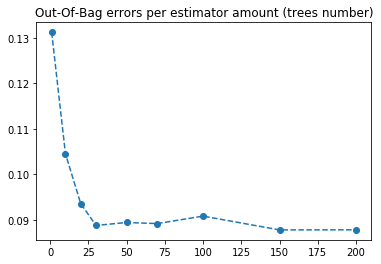

In [36]:
plt.title("Out-Of-Bag errors per estimator amount (trees number)")
plt.errorbar(n_trees, oob_errors, fmt='--o');

### Random Forest SkLearn class

In [37]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100)
# oob error not working, need to perform evaluation on test split
rfr.fit(trainVal_data, trainVal_values.ravel())
np.flip(np.argsort(rfr.feature_importances_))

array([ 50,  49,   3, 100,  51,  92,   2,  46,  93,  99,  43,  40,  44,
        41,  71,  69,  68,  62,  38,  74,  14,   4,  98,   6,  78,  10,
        91,  75,  76,  25,  17,  88,  90,  67,  59,  24,   7,  45,  23,
        39,  94,  29,  36,  31,   0,  18,  96,  22,  60,  21,   9,  30,
        89,  48,  35,  32,  15,  34,  95,  11,  27,  55,  73,  65,  16,
        82,  79,   8,   1,  97,  37,   5,  77,  19,  86,  47,  63,  33,
        28, 101,  26,  87,  42,  66,  72,  58,  64,  83,  61,  52,  54,
        20,  84,  13,  53,  57,  12,  85,  80,  56,  81,  70])

In [38]:
pred = rfr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.06966533520208767
Root Mean Square Error: 0.10247850538665117
R^2 score: 0.7481705824258656


# Predictors - Models definition

## 1. Regularised Least Squares
   

In [39]:
class tikhonov_leastSquares:
    def __init__(self, weights = None):
        self.weights = weights
        
    def fit(self, X, y, _lambda):
        inv = np.linalg.inv(np.matmul(X.T, X) + _lambda*np.eye(X.shape[1]))
        self.weights = np.matmul(inv, np.matmul(X.T, y))
        return self
    
    def predict(self, X):
        if self.weights is None:
            raise Exception("weights not initialised! need to first fit the model")
        return np.matmul(X, self.weights)

In [40]:
k = 5
params_dict = {"_lambda":[1,1.3,1.5,1.7,2]}

tls = tikhonov_leastSquares()

win_regulariser = kFold_crossValidation_selectionGrid(k, params_dict, trainVal_data, trainVal_values, tls)[0]
print("Best regulariser: {}".format(win_regulariser))
tls.fit(trainVal_data, trainVal_values, win_regulariser)
pred = tls.predict(test_data)

rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Best regulariser: 1.3
Residual variance: 0.01160705745374177
Root Mean Square Error: 0.1078997770895623
R^2 score: 0.7208214864982986


## 2. Random Forest

In [63]:
rf = NumericalRandomForest_regressor(100)
rf.fit(trainVal_data, trainVal_values, depth=100, minElems_perLeaf=10);

pred = rf.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.05947410227750999
Root Mean Square Error: 0.11147876491710357
R^2 score: 0.7019938735042794


In [42]:
rf.oob_error

0.09828329626705119

In [43]:
rf.sort_featureImportances()

[(39, 0.9110206377142744),
 (3, 0.8252768375368457),
 (2, 0.662166731582441),
 (46, 0.6128644300474198),
 (78, 0.5602364139160805),
 (0, 0.5485355111671377),
 (10, 0.4686934707265575),
 (40, 0.4595699058467275),
 (71, 0.4416502319456311),
 (75, 0.4393184427521904),
 (43, 0.4206398177634407),
 (30, 0.41447690858082525),
 (77, 0.40553293647082517),
 (20, 0.4009259089703996),
 (100, 0.40014559045407705),
 (69, 0.39855313728010494),
 (72, 0.3950750535725271),
 (41, 0.393545922778647),
 (50, 0.3673734817613748),
 (68, 0.3536992396841796),
 (91, 0.35290727972074504),
 (61, 0.32047967517444964),
 (57, 0.31667377426619914),
 (96, 0.3143594624038817),
 (98, 0.3136646218556004),
 (73, 0.31312708288026336),
 (63, 0.31005664288077606),
 (49, 0.306815629702226),
 (14, 0.3034790637021964),
 (74, 0.29866606564159953),
 (22, 0.2969694694156041),
 (28, 0.29553952246099596),
 (16, 0.29174341565385614),
 (51, 0.27679048673410833),
 (99, 0.2727251542368779),
 (38, 0.27194681865284287),
 (90, 0.26544074939

## 3. SVM - Not Working (use the sklearn model)

In [44]:
class linear_SupportVector_regression:
    def __init__(self, weight=None, alpha=None, bias=None):
        self.x = alpha
        self.w = weight
        self.bias = bias
        self.Nabla = None
                
    def SMO2_ab(self, n, H, f, a, LB, UB, maxiter, eps, alpha_s):
        """
        % min_{x} .5 x H x + f' x 
        %         LB <= x <= UB
        %         a' x = b
        % n         grandezza problema length(x)
        % maxiter   max num it
        % eps       precisione
        % alpha_s   punto di inizio valido per x
        % Nabla     ....
        % err       flag di ok
        % x         valore della soluzione ottima
        % bias      ....
        """
        self.x = alpha_s
        self.Nabla = f
        for i in range(n):
            if (self.x[i] != 0.0):
                for j in range(n):
                    self.Nabla[j] += H[j,i] * self.x[i]
        iter_ = 0
        while True:
            minF_up = float("inf");
            maxF_low = float("-inf");
            for i in range(n): 
                F_i = self.Nabla[i]/a[i]
                if (LB[i] < self.x[i]) and (self.x[i] < UB[i]) :
                    if (minF_up > F_i):
                        minF_up = F_i
                        u = i
                    if (maxF_low < F_i):
                        maxF_low = F_i
                        v = i
                elif (((a[i] > 0) and (self.x[i] == LB[i])) or ((a[i] < 0) and (self.x[i] == UB[i]))) : 
                    if (minF_up > F_i):
                        minF_up = F_i
                        u = i
                elif (((a[i] > 0) and (self.x[i] == UB[i])) or ((a[i] < 0) and (self.x[i] == LB[i]))) : 
                    if (maxF_low < F_i):
                        maxF_low = F_i
                        v = i
            if ((maxF_low - minF_up) <= eps):
                err = 0.0
                break

            iter_ += 1
            if (iter_ >= maxiter):
                err = 1.0
                break

            if (a[u] > 0):
                tau_lb = (LB[u]-self.x[u])*a[u] 
                tau_ub = (UB[u]-self.x[u])*a[u] 
            else:
                tau_ub = (LB[u]-self.x[u])*a[u] 
                tau_lb = (UB[u]-self.x[u])*a[u]

            if (a[v] > 0):
                tau_lb = max(tau_lb,(self.x[v]-UB[v])*a[v]) 
                tau_ub = min(tau_ub,(self.x[v]-LB[v])*a[v]) 
            else:
                tau_lb = max(tau_lb,(self.x[v]-LB[v])*a[v]) 
                tau_ub = min(tau_ub,(self.x[v]-UB[v])*a[v])

            tau = (self.Nabla[v]/a[v]-self.Nabla[u]/a[u])/(H[u,u]/(a[u]*a[u])
                                                           +H[v,v]/(a[v]*a[v])
                                                           -2*H[v,u]/(a[u]*a[v]))
            tau = min(max(tau,tau_lb),tau_ub)
            self.x[u] += tau/a[u]
            self.x[v] -= tau/a[v]

            for i in range(n):
                self.Nabla[i] += H[u,i]*tau/a[u] - H[v,i]*tau/a[v]

        tsv = 0
        self.bias = 0.0

        for k in range(n):
            if ((self.x[k] > LB[k]) and (self.x[k] < UB[k])):
                self.bias -= self.Nabla[k]/a[k]
                tsv += 1

        if (tsv > 0):
            self.bias /= tsv
        else:    
            self.bias = -(maxF_low + minF_up)/2.0

        return err
    
    def fit(self, X, y, C):
        n = X.shape[0]
        cov = np.matmul(X, X.T)
        Q = np.matmul(np.matmul(np.diag(y.flatten()), cov),
                      np.diag(y.flatten()))
        
        if self.SMO2_ab(n,Q,-np.ones(n),y.flatten(),
                   np.zeros(n),C*np.ones(n),10000000,.0001,np.zeros(n)):
            print("Problem in SMO")
            
        self.w = np.matmul(np.matmul(X.T, np.diag(y.flatten())),
                           self.x)
        
        return self
    
    def predict(self, X):
        return np.matmul(X, self.w) + self.bias

In [45]:
lsvr = linear_SupportVector_regression()
lsvr.fit(trainVal_data, trainVal_values, C=1.0);

pred = lsvr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 6.399482291880672
Root Mean Square Error: 9.058969844025647
R^2 score: -1966.8795992349653


In [46]:
np.where(lsvr.x)

(array([   8,   17,   90,  104,  125,  156,  239,  241,  244,  254,  267,
         300,  375,  389,  464,  514,  569,  580,  595,  615,  628,  642,
         707,  743,  831,  856,  857,  918,  987, 1003, 1013, 1076, 1095,
        1108, 1118, 1194, 1208, 1319, 1445, 1468]),)

In [47]:
from sklearn.svm import SVR
svr = SVR(kernel="linear", tol=.0001, C=1)
svr.fit(trainVal_data, trainVal_values.flatten());

In [48]:
np.where(svr.dual_coef_)[1]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [49]:
pred = svr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.07308253361834248
Root Mean Square Error: 0.10832676960510007
R^2 score: 0.7186075244570947


# Recursive Features Elimination
<img src="img/Algo1.png">

In [50]:
nrf = NumericalRandomForest_regressor(100)
nrf.fit(trainVal_data, trainVal_values, depth=200, minElems_perLeaf=5, verbose=True);

	Fitting #1 tree
	Fitting #2 tree
	Fitting #3 tree
	Fitting #4 tree
	Fitting #5 tree
	Fitting #6 tree
	Fitting #7 tree
	Fitting #8 tree
	Fitting #9 tree
	Fitting #10 tree
	Fitting #11 tree
	Fitting #12 tree
	Fitting #13 tree
	Fitting #14 tree
	Fitting #15 tree
	Fitting #16 tree
	Fitting #17 tree
	Fitting #18 tree
	Fitting #19 tree
	Fitting #20 tree
	Fitting #21 tree
	Fitting #22 tree
	Fitting #23 tree
	Fitting #24 tree
	Fitting #25 tree
	Fitting #26 tree
	Fitting #27 tree
	Fitting #28 tree
	Fitting #29 tree
	Fitting #30 tree
	Fitting #31 tree
	Fitting #32 tree
	Fitting #33 tree
	Fitting #34 tree
	Fitting #35 tree
	Fitting #36 tree
	Fitting #37 tree
	Fitting #38 tree
	Fitting #39 tree
	Fitting #40 tree
	Fitting #41 tree
	Fitting #42 tree
	Fitting #43 tree
	Fitting #44 tree
	Fitting #45 tree
	Fitting #46 tree
	Fitting #47 tree
	Fitting #48 tree
	Fitting #49 tree
	Fitting #50 tree
	Fitting #51 tree
	Fitting #52 tree
	Fitting #53 tree
	Fitting #54 tree
	Fitting #55 tree
	Fitting #56 tree
	

In [51]:
print("Features sorted by their score:\n")
nrf.sort_featureImportances()

Features sorted by their score:



[(15, 1.2667524423089707),
 (49, 1.2172819021391184),
 (28, 1.2166564500118702),
 (78, 1.1326225732468072),
 (0, 0.868117099177149),
 (50, 0.8532842851096637),
 (39, 0.80421147423288),
 (44, 0.7668728101124096),
 (38, 0.7177620499480079),
 (42, 0.7155394471381687),
 (2, 0.6919078701983675),
 (100, 0.6827767846690378),
 (51, 0.666603083891823),
 (46, 0.6626017133146643),
 (4, 0.6401371923312802),
 (40, 0.6238594648811658),
 (43, 0.6159912525316843),
 (3, 0.6104394820962873),
 (61, 0.5788099002788748),
 (10, 0.541403292081756),
 (14, 0.5301586271627494),
 (45, 0.5242100397772046),
 (32, 0.5180017189917707),
 (48, 0.5088652391621283),
 (62, 0.49947803723429635),
 (17, 0.47169686580005404),
 (30, 0.468331705716618),
 (16, 0.4573196515383959),
 (91, 0.44981002174248763),
 (12, 0.4443974996992389),
 (6, 0.4369008703644815),
 (41, 0.43003828801409444),
 (67, 0.4214263078132912),
 (99, 0.41464557786989387),
 (56, 0.41281149611187984),
 (89, 0.40857486928099845),
 (68, 0.4061050166410038),
 (26

In [52]:
print("Features sorted by their score:\n")
nrf.sort_featureImportances(columns=pred_features.columns)

Features sorted by their score:



[('pctWInvInc', 1.2668),
 ('NumKidsBornNeverMar', 1.2173),
 ('PctPopUnderPov', 1.2167),
 ('PctWOFullPlumb', 1.1326),
 ('population', 0.8681),
 ('PctKidsBornNeverMar', 0.8533),
 ('MalePctNevMarr', 0.8042),
 ('PctKids2Par', 0.7669),
 ('MalePctDivorce', 0.7178),
 ('PersPerFam', 0.7155),
 ('racepctblack', 0.6919),
 ('PctUsePubTrans', 0.6828),
 ('NumImmig', 0.6666),
 ('PctTeen2Par', 0.6626),
 ('racePctAsian', 0.6401),
 ('FemalePctDiv', 0.6239),
 ('PctFam2Par', 0.616),
 ('racePctWhite', 0.6104),
 ('PctNotSpeakEnglWell', 0.5788),
 ('numbUrban', 0.5414),
 ('pctWFarmSelf', 0.5302),
 ('PctYoungKids2Par', 0.5242),
 ('PctUnemployed', 0.518),
 ('PctWorkMom', 0.5089),
 ('PctLargHouseFam', 0.4995),
 ('pctWPubAsst', 0.4717),
 ('PctNotHSGrad', 0.4683),
 ('pctWSocSec', 0.4573),
 ('NumInShelters', 0.4498),
 ('medIncome', 0.4444),
 ('agePct12t21', 0.4369),
 ('TotalPctDiv', 0.43),
 ('PctPersOwnOccup', 0.4214),
 ('PopDens', 0.4146),
 ('PctRecentImmig', 0.4128),
 ('MedOwnCostPctInc', 0.4086),
 ('PctPersDense

In [64]:
def rfe(estimator, parameters_dict, data, vals, n_features=None, verbose=False):
    _,d = data.shape
    nf = n_features if n_features else int(d/2)
    train_feat = list(range(d))    
    rmse = []
    r2 = []

    tr_data, ts_data, tr_vals, ts_vals = trainTest_split(in_matrix=data, out_vect=vals, train_amount=0.7)
    
    while d > nf:
        if verbose:
            update = round((data.shape[1]-d)*100/(data.shape[1]-nf), 2) # just print completion rate
            print("\t["+'#'*(int(update/5))+' '*(int((100-update)/5))+"] {}%".format(update))
            
        estimator.fit(X=tr_data[:,train_feat], y=tr_vals, **parameters_dict)
        pred = estimator.predict(ts_data)
        rem = Regression_evaluationMetric(ts_vals, pred)
        rmse.append(rem.rootMeanSquareError())
        r2.append(rem.rSquared())
            
        rank = estimator.sort_featureImportances()
        toDiscard_idx = rank[-1][0]
        train_feat.remove(train_feat[toDiscard_idx])

        d -= 1
    
    return (rmse, r2, train_feat)

In [65]:
p_dict = {"depth":200, "minElems_perLeaf":5, "post_pruning":True, "verbose":False}
rootMSE, r2, surv_feature = rfe(NumericalRandomForest_regressor(100),
                                p_dict, trainVal_data, trainVal_values, verbose=True)

	[                    ] 0.0%
	[                   ] 1.96%
	[                   ] 3.92%
	[#                  ] 5.88%
	[#                  ] 7.84%
	[#                  ] 9.8%
	[##                 ] 11.76%
	[##                 ] 13.73%
	[###                ] 15.69%
	[###                ] 17.65%
	[###                ] 19.61%
	[####               ] 21.57%
	[####               ] 23.53%
	[#####              ] 25.49%
	[#####              ] 27.45%
	[#####              ] 29.41%
	[######             ] 31.37%
	[######             ] 33.33%
	[#######            ] 35.29%
	[#######            ] 37.25%
	[#######            ] 39.22%
	[########           ] 41.18%
	[########           ] 43.14%
	[#########          ] 45.1%
	[#########          ] 47.06%
	[#########          ] 49.02%
	[##########         ] 50.98%
	[##########         ] 52.94%
	[##########         ] 54.9%
	[###########        ] 56.86%
	[###########        ] 58.82%
	[############       ] 60.78%
	[############       ] 62.75%
	[############     

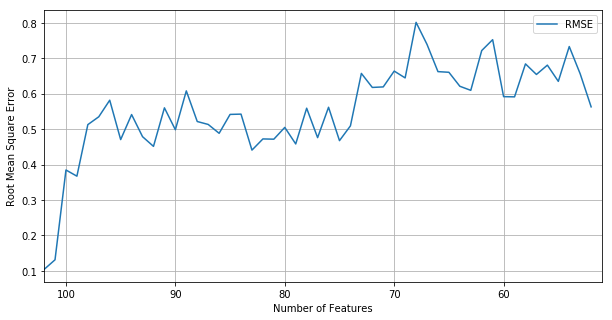

In [67]:
plt.figure(figsize=(10,5))
x = range(trainVal_data.shape[1],len(surv_feature),-1)
plt.plot(x, rootMSE, label="RMSE")
#plt.plot(x, r2, label="R2")

plt.legend()
plt.xlim(trainVal_data.shape[1], len(surv_feature))
#range(trainVal_data.shape[1],len(surv_feature),-1)
plt.xlabel("Number of Features")
plt.ylabel("Root Mean Square Error")
plt.grid()

In [58]:
rootMSE

[0.15950524950718215,
 0.17113526202722198,
 0.31529633306745614,
 0.309950081678997,
 0.3545869863238208,
 0.40335021015983974,
 0.3743350930716753,
 0.3618972835676513,
 0.453821694961102,
 0.3617319645207951,
 0.39832492034570766,
 0.4168825685150099,
 0.45982945268396214,
 0.43804417938353263,
 0.44192025399237156,
 0.4535934167529332,
 0.44784436734379296,
 0.4218520024826061,
 0.4329530733864868,
 0.3823140356736881,
 0.3899390965536767,
 0.3877585713425083,
 0.37387087260073626,
 0.38131333143736595,
 0.4271516323149062,
 0.3960745391358284,
 0.3355870069439423,
 0.41705623799445174,
 0.4088092397084685,
 0.39809280390637763,
 0.46078522012151074,
 0.4618297192716776,
 0.42619600357023574,
 0.4151428881855723,
 0.4456670423017163,
 0.4347062214254675,
 0.4470225862166969,
 0.4074430650970377,
 0.40951092726528265,
 0.4236516491027642,
 0.3943130179699116,
 0.43552630608930976,
 0.3707150524265042,
 0.45320788489613484,
 0.4076676186576423,
 0.37625987004343076,
 0.38569277320142

In [59]:
pred_features.columns[surv_feature]

Index(['population', 'householdsize', 'racePctWhite', 'racePctAsian',
       'agePct12t21', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctWWage',
       'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'medFamInc', 'whitePerCap',
       'blackPerCap', 'indianPerCap', 'NumUnderPov', 'PctPopUnderPov',
       'PctLess9thGrade', 'PctEmplProfServ', 'PctOccupManu', 'MalePctDivorce',
       'MalePctNevMarr', 'TotalPctDiv', 'PctFam2Par', 'PctKids2Par',
       'PctWorkMomYoungKids', 'NumKidsBornNeverMar', 'PctKidsBornNeverMar',
       'NumImmig', 'PctImmigRec8', 'PctImmigRec10', 'PctRecImmig5',
       'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouseOccup',
       'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup',
       'PctPersDenseHous', 'PctHousLess3BR', 'HousVacant', 'PctVacantBoarded',
       'MedYrHousBuilt', 'PctWOFullPlumb', 'OwnOccHiQuart', 'RentMedian',
       'MedRentPctHousInc', 'PctSameHouse85', 'PopDens', 'PctUsePubTrans'],
      dtype='object')